# Clustering
   
**Clustering with K-means**   
Now, the idea is to find some type of clustering to see if there is any pattern in the data that might provide some insigths.  

First, clean the data to prepare for the analysis. 
Then, define the amount of clusters by applying the elbow test
Finally, apply k-means and get the labels assigned
Once we have the labels we have to analyze the results 


## Countries

In [24]:
# create year, month columns from the date 
df['year'] = pd.to_datetime(df['InvoiceDate']).dt.strftime('%Y')
df['month'] = pd.to_datetime(df['InvoiceDate']).dt.strftime('%m')
df['sales'] = df['Quantity']*df['UnitPrice']
df = map_countries(df)

/opt/anaconda2/envs/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda2/envs/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda2/envs/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be 

In [25]:
#drop unnecessary columns
df_aux = df.drop(['Description','InvoiceNo','InvoiceDate','UnitPrice','CustomerID'], axis=1, inplace=False)

#group by some columns and take the sum 
df_aux = df_aux.groupby(['StockCode','year','month', 'Country']).sum().reset_index()

# transform StockCode to integers
df_aux['StockCode'] = df_aux['StockCode'].astype('category').cat.codes
df_aux

,StockCode,year,month,Country,Quantity,cancelled,sales
0,0,2010,12,EIRE,12,0,10.20
1,0,2010,12,France,96,0,81.60
2,0,2010,12,United Kingdom,116,0,98.60
3,0,2011,01,France,156,0,132.60
4,0,2011,01,Germany,1,0,0.85
...,...,...,...,...,...,...,...
62470,3683,2011,12,Greece,3,0,135.00
62471,3683,2011,12,Norway,1,0,40.00
62472,3683,2011,12,Portugal,14,0,392.00
62473,3683,2011,12,Spain,1,0,28.00


Scale the data 

In [26]:
# study clusters without United Kingdom
from sklearn.preprocessing import scale
df_aux_1 = df_aux[df_aux['Country']!='United Kingdom'].copy()

x = df_aux_1.drop(['Country'],axis=1)
x = scale(x)

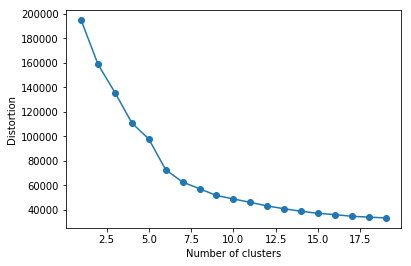

7


In [27]:
import numpy as np
from sklearn.cluster import KMeans
from kneed import KneeLocator

def elbow_test(df, n_init, max_clusters, max_iter):
    distortions = []
    for i in range(1, max_clusters):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=n_init, max_iter=max_iter,
            tol=1e-04, random_state=0
        )
        km.fit(df)
        distortions.append(km.inertia_)

    plt.plot(range(1, max_clusters), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    
    kn = KneeLocator(
        range(1, max_clusters),
        distortions,
        curve='convex',
        direction='decreasing',
        interp_method='interp1d',
    )
    return kn.knee

n_clusters = elbow_test(x, 10, 20, 300)
print(n_clusters)

In [28]:
km = KMeans(n_clusters=n_clusters, random_state=20)
y = km.fit_predict(x)
#add column that determines the cluster assigned 
df_aux_1['cluster'] = km.labels_

Plot the clusters into the map to see if there is a relationship with the countries. 

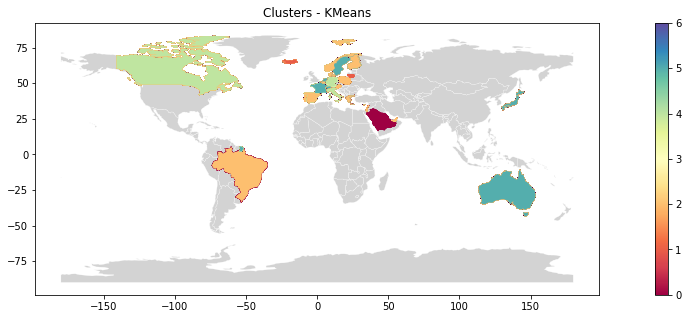

In [29]:
plot_countries(df_aux_1, 'Clusters - KMeans', 'Country', 'cluster', True)

We can plot a scatter plot for two of the variables and see how the relationship between them has influence in the division of the clusters

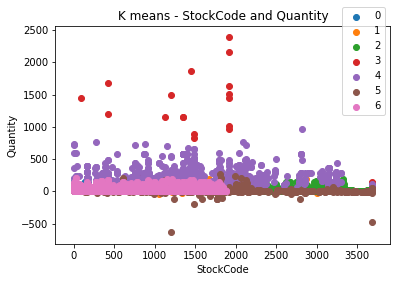

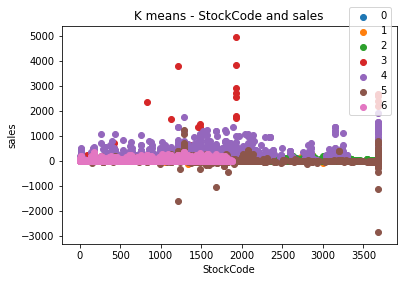

In [30]:
def draw_scatter(df, col_1, col_2, cluster_column, num_clusters, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        axs.append(ax.scatter(df[df[cluster_column]==i][col_1], df[df[cluster_column]==i][col_2], cmap=colors[i]))
    
    ax.legend(axs, labels, loc='center', bbox_to_anchor=(0.92, 0.84), ncol=1)
    plt.show()

draw_scatter(df_aux_1, 'StockCode', 'Quantity', 'cluster', n_clusters, 'K means - StockCode and Quantity')
draw_scatter(df_aux_1, 'StockCode', 'sales', 'cluster', n_clusters, 'K means - StockCode and sales')

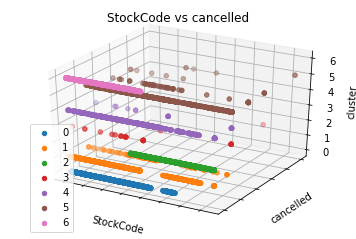

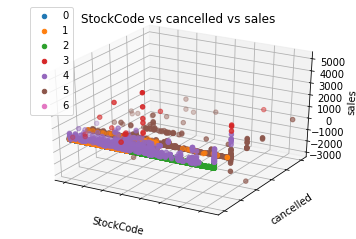

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def create_3d_scatter(df, col_1, col_2, col_3, cluster_column, num_clusters, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    ax.set_zlabel(col_3)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        d = df[df[cluster_column]==i]
        axs.append(ax.scatter(d[col_1], d[col_2], d[col_3], cmap=colors[i]))
    
    ax.legend(axs, labels, bbox_to_anchor=(0.2, 0.5), ncol=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()

create_3d_scatter(df_aux_1, 'StockCode', 'cancelled', 'cluster', 'cluster', n_clusters, 'StockCode vs cancelled')
create_3d_scatter(df_aux_1, 'StockCode', 'cancelled', 'sales', 'cluster', n_clusters, 'StockCode vs cancelled vs sales')


## Customers

In [32]:
#see who bought more for each product 
products = df[['StockCode', 'CustomerID', 'sales']].groupby(['StockCode', 'CustomerID']).count().reset_index()

# for each product keep top 10 sales
products_df = pd.DataFrame()
for p in products['StockCode'].unique():
    p_df = products[products['StockCode']==p].sort_values('sales', ascending=False).reset_index()
    p_df = p_df[0:10]
    products_df = products_df.append(p_df)

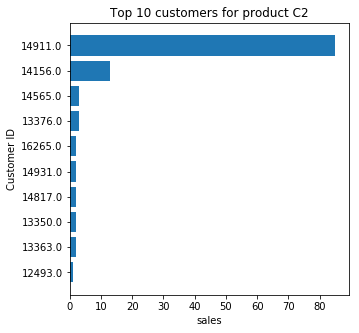

In [33]:
def plot_sales_per_customer(df, stockCode):
    stock_product = df[df['StockCode']==stockCode]
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.invert_yaxis()
    ax.barh(y=stock_product.index, width='sales', data=stock_product)
    ax.set_yticks(range(0,10))
    ax.set_yticklabels(stock_product['CustomerID'].tolist())
    ax.set_ylabel('Customer ID')        
    ax.set_xlabel('sales')      
    ax.set_title("Top 10 customers for product " + stockCode)    
    plt.show()

plot_sales_per_customer(products_df, 'C2')

Keep information relevant for each customer:
- total amount of purchases
- start date
- how many different products the customer bought
- total money spent
- last date purchase

In [34]:
#total amount of purchases
customers = df[df['cancelled']==0][['InvoiceNo','CustomerID']]
customers = customers.groupby(['CustomerID']).count().reset_index()
customers.rename(columns={'InvoiceNo':'total_purchases'}, inplace=True)

In [35]:
#start date
aux = df.copy()
aux = aux[['CustomerID', 'InvoiceDate']].groupby(['CustomerID']).min().reset_index()
aux['InvoiceDate'] = pd.to_datetime(aux['InvoiceDate'])
aux['start_year'] = aux['InvoiceDate'].dt.strftime('%Y')
aux['start_month'] = aux['InvoiceDate'].dt.strftime('%m')
aux['start_day'] = aux['InvoiceDate'].dt.strftime('%d')
aux['start_hour'] = aux['InvoiceDate'].dt.strftime('%H')
aux.drop(['InvoiceDate'], axis=1, inplace=True)
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')
print(customers.isnull().sum())
customers.fillna(0, inplace=True)

CustomerID          0
total_purchases    33
start_year          0
start_month         0
start_day           0
start_hour          0
dtype: int64


In [36]:
#how many different products the customer bought
aux = df[['CustomerID','StockCode']].groupby(['CustomerID']).count().reset_index()
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')
customers.rename(columns={'StockCode':'Products'}, inplace=True)

In [37]:
#total money spent
aux = df.copy()
aux['spent'] = aux['Quantity']*aux['UnitPrice']
aux = aux[['CustomerID','spent']].groupby(['CustomerID']).sum().reset_index()
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')
customers.rename(columns={'StockCode':'Products'}, inplace=True)
customers['spent'] = customers['spent'].apply(lambda x: x if x>0 else 0)

In [38]:
#last date purchase
aux = df.copy()
aux = aux[['CustomerID', 'InvoiceDate']].groupby(['CustomerID']).max().reset_index()
aux['InvoiceDate'] = pd.to_datetime(aux['InvoiceDate'])
aux['last_year'] = aux['InvoiceDate'].dt.strftime('%Y')
aux['last_month'] = aux['InvoiceDate'].dt.strftime('%m')
aux['last_day'] = aux['InvoiceDate'].dt.strftime('%d')
aux['last_hour'] = aux['InvoiceDate'].dt.strftime('%H')
aux.drop(['InvoiceDate'], axis=1, inplace=True)
customers = customers.merge(aux, how='outer', left_on='CustomerID', right_on='CustomerID')
print(customers.isnull().sum())
customers.fillna(0, inplace=True)

CustomerID         0
total_purchases    0
start_year         0
start_month        0
start_day          0
start_hour         0
Products           0
spent              0
last_year          0
last_month         0
last_day           0
last_hour          0
dtype: int64


In [39]:
customers.columns

Index(['CustomerID', 'total_purchases', 'start_year', 'start_month',
       'start_day', 'start_hour', 'Products', 'spent', 'last_year',
       'last_month', 'last_day', 'last_hour'],
      dtype='object')

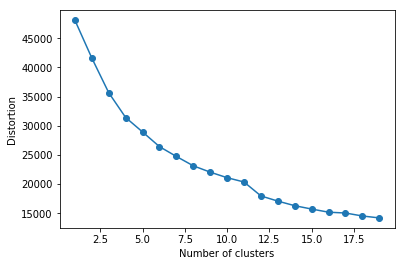

number of clusters: 6


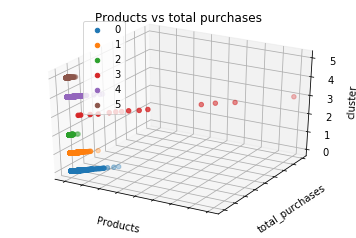

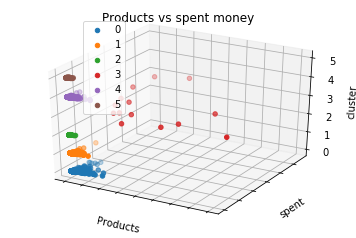

In [40]:
##apply k-means 
x = customers.drop(['CustomerID'],axis=1)
x = scale(x)
n_clusters = elbow_test(x, 10, 20, 300)
print('number of clusters:',n_clusters)
km = KMeans(n_clusters=n_clusters, random_state=20)
y = km.fit_predict(x)
#add column that determines the cluster assigned 
customers['cluster'] = km.labels_

#clients who made similar amount of purchases, buy similar products
create_3d_scatter(customers, 'Products', 'total_purchases', 'cluster', 'cluster', n_clusters, 'Products vs total purchases')

#while cluster 3 is more spread, generally the clients buy the same kind of products. Cluster 3 is the only one that has clients who spent more money 
create_3d_scatter(customers, 'Products', 'spent', 'cluster', 'cluster', n_clusters, 'Products vs spent money')

## Products

In [41]:
from wordcloud import WordCloud

#check codes that contain only letters
codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
for code in codes:
    print("{:} : {}".format(code, df[df['StockCode'] == code]['Description'].unique()[0]))

POST : POSTAGE
D : Discount
C2 : CARRIAGE
M : Manual
BANK CHARGES : Bank Charges
PADS : PADS TO MATCH ALL CUSHIONS
DOT : DOTCOM POSTAGE
CRUK : CRUK Commission


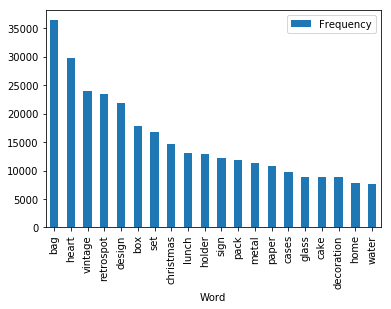

In [42]:
import nltk
df['Description'] = df['Description'].str.lower()
a = df['Description'].str.cat(sep=" ")
words = nltk.tokenize.word_tokenize(a)
words = [word for (word, pos) in nltk.pos_tag(words) if pos[:2]=='NN'] 
word_dist = nltk.FreqDist(words)
words = pd.DataFrame(word_dist.items(), columns=['Word', 'Frequency'])
words.sort_values(by='Frequency', ascending=False, inplace=True)
words[['Word','Frequency']].head(20).plot.bar(x='Word', y='Frequency', rot=90)

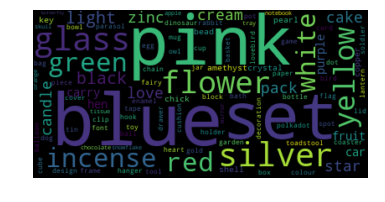

In [43]:
import matplotlib.pyplot as plt
def generate_plot(ax, text, max_words=1000):
    wordcloud = WordCloud(max_words=max_words).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    return ax
    
text = " ".join(word for word in word_dist)
fig = plt.figure()
ax = fig.add_subplot(111)
ax = generate_plot(ax, text, 100)
plt.show()

In [44]:
df_sample = df['Description'].sample(frac=0.5, random_state=1).reset_index()
df_sample.head()

,index,Description
0,443133,love garland painted zinc
1,415129,monsters stencil craft
2,192840,12 pencils tall tube posy
3,32503,ladies & gentlemen metal sign
4,228211,childrens cutlery spaceboy


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=1000)
X = vectorizer.fit_transform(df_sample['Description'])

In [46]:
n_clusters = 5
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

Top 10 terms per cluster


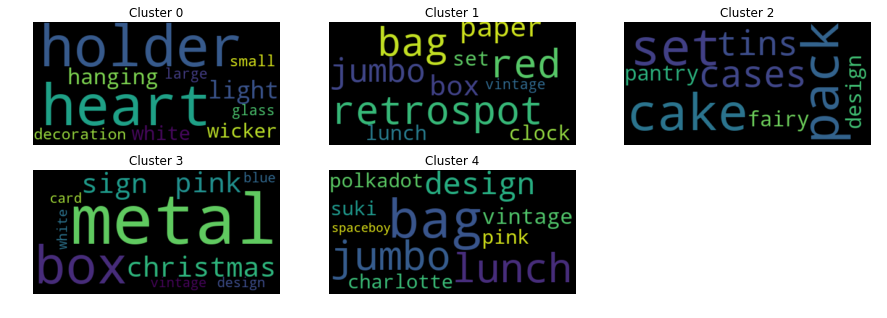

In [47]:
# get the clusters centers and order them 
# .argsort()[:, ::-1] line converts each centroid into a sorted
# list of the columns most relevant words 
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
top_n = 10
print("Top {} terms per cluster".format(top_n))
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
n = int(n_clusters/2) +1
fig, axs = plt.subplots(2, n, figsize=(15,5))
x = 0
y = 0
terms_vectorize = np.vectorize(lambda x: terms[x])
for i in range(n_clusters):
    text = " ".join(word for word in terms_vectorize(order_centroids[i, :top_n]))
    axs[x,y] = generate_plot(axs[x,y], text, 100)
    axs[x,y].set_title("Cluster " + str(i))
    y_aux = (y+1)%n
    if (y_aux < y):
        x = (x+1)%2
    y = y_aux

for ax in axs:
    for d in ax:
        d.axis("off")
plt.show()    

From the words we can see that:
cluster 0: decoration
cluster 1: 
cluster 2: present
cluster 3: 
cluster 4: others

In [48]:
print("Find cluster for product ", df['Description'][0])
prediction = kmeans_model.predict(vectorizer.transform([df['Description'][0]]))
print('Assigned cluster ', prediction)

Find cluster for product  white hanging heart t-light holder
Assigned cluster  [0]
